
<h1><font color=red>Building a Recommender using AutoMLx</font></h1>
<p style="margin-left:5%; margin-right:5%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

Recommendation Demo Notebook.

Copyright © 2024, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

# Overview of this Notebook

In this notebook we will build a recommender using the Oracle AutoMLx tool for the Movielens 100k dataset to predict the next item that users will most likely watch, based on their ratings history.
We explore the various options provided by the Oracle AutoMLx tool, allowing the user to control the AutoMLx training process. We finally evaluate the different models trained by AutoMLx. Depending on the machine running this notebook, it can take up to minutes.

---
## Prerequisites:

   - Experience level: Novice (Python and Machine Learning)
   - Professional experience: Some industry experience
---

## Business Use:

Data analytics and modeling problems using Machine Learning (ML) are becoming popular and often rely on data science expertise to build accurate ML models. Such modeling tasks primarily involve the following steps:
- Preprocess dataset (clean, impute, engineer features, normalize).
- Pick an appropriate model for the given dataset and prediction task at hand.
- Tune the chosen model’s hyperparameters for the given dataset.

All of these steps are significantly time consuming and heavily rely on data scientist expertise. Unfortunately, to make this problem harder, the best feature subset, model, and hyperparameter choice widely varies with the dataset and the prediction task. Hence, there is no one-size-fits-all solution to achieve reasonably good model performance. Using a simple Python API, AutoML can quickly jump-start the datascience process with an accurately-tuned model and appropriate features for a given prediction task.

## Table of Contents

- <a href='#setup'> Setup</a>
- <a href='#load-data'> Load the Movielens 100k dataset</a>
  - <a href='#coltypes'> Define the column types</a>
  - <a href='#dataset-split'>Splitting the dataset</a>
- <a href='#automl'> AutoML</a>
  - <a href='#provider'> Create an Instance of AutoMLx</a>
  - <a href='#default'> Train a Model using AutoMLx</a>
  - <a href='#recommending'> Generate recommendations </a>
  - <a href='#analyze'> Analyze the AutoMLx optimization process </a>
      - <a href='#algorithm-selection'> Algorithm Selection</a>
      - <a href='#hyperparameter-tuning'> Hyperparameter Tuning</a>
  - <a href='#modellist'> Advanced AutoMLx Configuration</a>
  - <a href='#custom-validation'> Use a custom validation set</a>
  - <a href='#evaluation'> Final evaluation of the best model</a>

<a id='setup'></a>
## Setup

Basic setup for the Notebook.

In [1]:


import datetime
import logging
import os
import time
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from automlx import AutoRecommender, init

# Settings for plots
plt.rcParams["figure.figsize"] = [10, 7]
plt.rcParams["font.size"] = 15

# Silence unnecessary warnings
logging.getLogger("sanerec.autotuning.parameter").setLevel(logging.ERROR)

# Initialize the parallelization engine of AutoMLx
init(engine='ray', engine_opts={"ray_setup": {"log_to_driver": False}})

[2024-09-11 08:30:41,179] [automlx.backend] Overwriting ray session directory to /tmp/kfognjfx/ray, which will be deleted at engine shutdown. If you wish to retain ray logs, provide _temp_dir in ray_setup dict of engine_opts when initializing the AutoMLx engine.


<a id='load-data'></a>
## Load Movielens 100k data
Movielens 100k dataset is one of the most common public datasets for movie recommendation. It contains 100k ratings from about 1k users on 1.6k movies, some information about user demographic, and additional movie characteristics. For more information about this dataset, you can visit the [Movielens website](https://grouplens.org/datasets/movielens/100k/).

In this demo, we use the ratings to train a movie recommendation model, exploiting AutoMLx to find the best recommendation model and hyperparameters to use in terms of recommendation accuracy.
Therefore, we start retrieving and loading the ratings data of the Movielens 100k dataset.
To make this notebook lighter and quicker, we also subsample the ratings in the dataset, keeping only 50%.

In [2]:


get_ipython().system(' wget https://files.grouplens.org/datasets/movielens/ml-100k/u.data --no-check-certificate -q -O ./ml100k_interactions.tsv')

In [3]:


dataset = pd.read_csv(
    "./ml100k_interactions.tsv",
    sep="\t",
    names=["user_id", "movie_id", "rating", "timestamp"],
).sample(frac=0.5, random_state=1)

dataset.head(5)

,user_id,movie_id,rating,timestamp
43660,508,185,5,883777430
87278,518,742,5,876823804
14317,178,28,5,882826806
81932,899,291,4,884122279
95321,115,117,4,881171009


In order to be used for the recommendation task, the data must have a timestamp column that is used to infer the temporal order of the samples. We also require to set the timestamp column as index of the dataframes used in our AutoML pipelines.

Movielens contains a `timestamp` column that contains the time when a rating was given, so we set it as index of our dataframe.

In [4]:


dataset = dataset.set_index("timestamp")
dataset.head(5)

,user_id,movie_id,rating
timestamp,,,
883777430,508,185,5
876823804,518,742,5
882826806,178,28,5
884122279,899,291,4
881171009,115,117,4


<a id='coltypes'></a>
### Define types of columns in the dataframe

The recommendation task requires to define the two main entities involved in the recommendation:
- the `recommendation`, which represents the entity type that is going to be recommended;
- the `recommendation_subject`, which represents the entity type that receives the recommendation.

For this reason, AutoML requires to indicate what are the columns in the dataset that refer to these two concepts, and, in particular, the two columns that contain their unique identifiers.

In our demo we want to recommend movies (`recommendation`), identified by the `movie_id` column, to users (`recommendation_subject`), identified by the `user_id` column. We declare this binding in a python dictionary that we will reuse throughout the demo.

In [5]:


col_types = {"movie_id": "recommendation", "user_id": "recommendation_subject"}

<a id='dataset-split'></a>
## Splitting the dataset

We split the dataset into training and test datasets using a leave-last-out technique.
The training set will be used to create a Machine Learning model using Oracle AutoMLx, and the test set will be used to evaluate the model's performance on unseen data.

The leave-last-out splitting technique consists in keeping in the test set only the last data sample, as determined by its timestamp, for each `recommendation_subject` (user in this case). All the other samples form the training set. This corresponds to the common next item recommendation use case, where given the history of all the past data concerning a `recommendation_subject` in the training set, we want to predict what should be recommended next to the same subject, and check if it corresponds to the actual sample in the test set.

In [6]:


training_data, test_data = AutoRecommender.train_test_split(data=dataset, col_types=col_types)

<a id='automl'></a>
# AutoML

<a id='provider'></a>
## Create an instance of Oracle AutoMLx

The Oracle AutoMLx solution provides a pipeline that automatically finds a tuned model given a prediction task and a training dataset. In particular, it allows finding a tuned model for any supervised prediction task, for example, classification or regression where the target can be binary, categorical or real-valued.

In this demo we want a model that performs a recommendation task, so we create a pipeline of type `AutoRecommender`, and we configure it with default parameters. You can find the complete list of all the available parameters and their meaning in our documentation.

In [7]:


automl_pipeline = AutoRecommender().configure()

<a id='default'></a>
## Train a model using AutoMLx

The training data is passed to the `fit()` function which executes the model selection and hyperparameter tuning steps.

In [8]:


automl_pipeline = automl_pipeline.fit(data=training_data, col_types=col_types)

[2024-09-11 08:30:50,830] [automlx.interface] Dataset shape: (49055,3)


[2024-09-11 08:30:50,900] [automlx.process] Running Model Generation


[2024-09-11 08:30:50,943] [automlx.process] Model Generation completed.


[2024-09-11 08:30:50,987] [automlx.model_selection] Running Model Selection


[2024-09-11 08:31:24,607] [automlx.model_selection] Model Selection completed - Took 33.620 sec - Selected models: [['ItemKNNRecommender']]


[2024-09-11 08:31:24,649] [automlx.trials] Running Model Tuning for ['ItemKNNRecommender']


[2024-09-11 08:31:39,575] [automlx.trials] Best parameters for ItemKNNRecommender: {'n_recommendations': 10, 'num_of_neighbors': 506, 'bias': 0.0001, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}


[2024-09-11 08:31:39,576] [automlx.trials] Model Tuning completed. Took: 14.926 secs


[2024-09-11 08:31:40,082] [automlx.interface] Re-fitting pipeline


[2024-09-11 08:31:40,092] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_e945b10c-f


[2024-09-11 08:31:41,009] [automlx.interface] AutoMLx completed.


<a id='recommending'></a>
## Generate recommendations

Once the AutoML pipeline is completed, we predict 5 recommendations for a random user in the dataset.

In [9]:


recommendation_subjects = test_data.sample(1)[['user_id']]
automl_pipeline.predict(subjects=recommendation_subjects, n_recommendations=5)

,user_id,movie_id,score
0,834,121,27.871420
1,834,7,27.642850
2,834,50,27.107165
3,834,405,26.306330
4,834,181,24.635577


<a id='analyze'></a>
## Analyze the AutoMLx optimization process

During the Oracle AutoMLx process for recommendation, a summary of the optimization process is logged, containing:
- Information about the training data.
- Information about the AutoMLx Pipeline, such as:
    - Selected algorithm that was the best choice for this data;
    - Selected hyperparameters for the selected algorithm.

AutoMLx provides a `print_summary` API to output all the different trials performed.

In [10]:


automl_pipeline.print_summary()

""
"(48114, 4)"
"(941, 4)"
"ManualSplit(Shuffle=False, Seed=7)"
SanerecMetric
ItemKNNRecommender
"{'n_recommendations': 10, 'num_of_neighbors': 506, 'bias': 0.0001, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}"
24.3.0
"3.8.19 (default, Mar 20 2024, 19:58:24) \n[GCC 11.2.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (SanerecMetric),Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 100, 'bias': 25, 'hist_len': 20, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0882,1.1723,0.7172,Wed Sep 11 08:31:01 2024
Model Selection,48114,2,AlsRecommender,"{'n_recommendations': 10, 'iterations': 10, 'factors': 16, 'regularization': 0.01, 'cache_users_states': True}",0.0723,3.8354,0.7012,Wed Sep 11 08:31:00 2024
Model Selection,48114,2,TRexxRecommender,"{'n_recommendations': 10, 'embedding_dim': 32, 'sequence_length': 5, 'num_sampled': 100, 'dropout_rate': 0.2, 'num_blocks': 2, 'num_head': 4, 'l2_reg_embedding': 1e-06, 'dnn_activation': 'tanh', 'optimizer_name': 'lazyadam', 'optimizer_learning_rate': 0.01, 'future_blinding': False, 'embeddings_on_cpu': False, 'cache_users_states': False, 'negative_sampling_method': CandidateSamplingMethod.UNIFORM_CANDIDATE_SAMPLING, 'epochs': 10, 'batch_size': 512, 'verbose': 1, 'augment_data': True, 'early_stopping_patience': -1}",0.0542,22.7016,1.1490,Wed Sep 11 08:31:24 2024
Model Selection,48114,2,BprRecommender,"{'n_recommendations': 10, 'iterations': 10, 'factors': 16, 'regularization': 0.01, 'cache_users_states': True}",0.051,0.3001,0.7042,Wed Sep 11 08:31:00 2024
Model Tuning,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 505, 'bias': 0.0001, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0999,1.4283,0.6178,Wed Sep 11 08:31:36 2024
Model Tuning,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 506, 'bias': 0.0001, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0999,1.1595,0.6175,Wed Sep 11 08:31:38 2024
Model Tuning,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 506, 'bias': 0.0001, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0999,1.6110,0.6170,Wed Sep 11 08:31:36 2024
Model Tuning,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 10, 'bias': 28.25660795027468, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0956,1.5365,0.6080,Wed Sep 11 08:31:34 2024
Model Tuning,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 10, 'bias': 28.26160794927468, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0956,1.2769,0.6095,Wed Sep 11 08:31:36 2024
Model Tuning,48114,2,ItemKNNRecommender,"{'n_recommendations': 10, 'num_of_neighbors': 10, 'bias': 28.26160794927468, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}",0.0956,1.5252,0.6092,Wed Sep 11 08:31:34 2024


We also provide the capability to visualize the results of each stage of the AutoMLx pipeline.

<a id='algorithm-selection'></a>
### Algorithm Selection

The plot below shows the scores predicted by Algorithm Selection for each algorithm. The horizontal line shows the average score across all algorithms. Algorithms below the line are colored turquoise, whereas those with a score higher than the mean are colored teal. The selected algorithm is in orange.

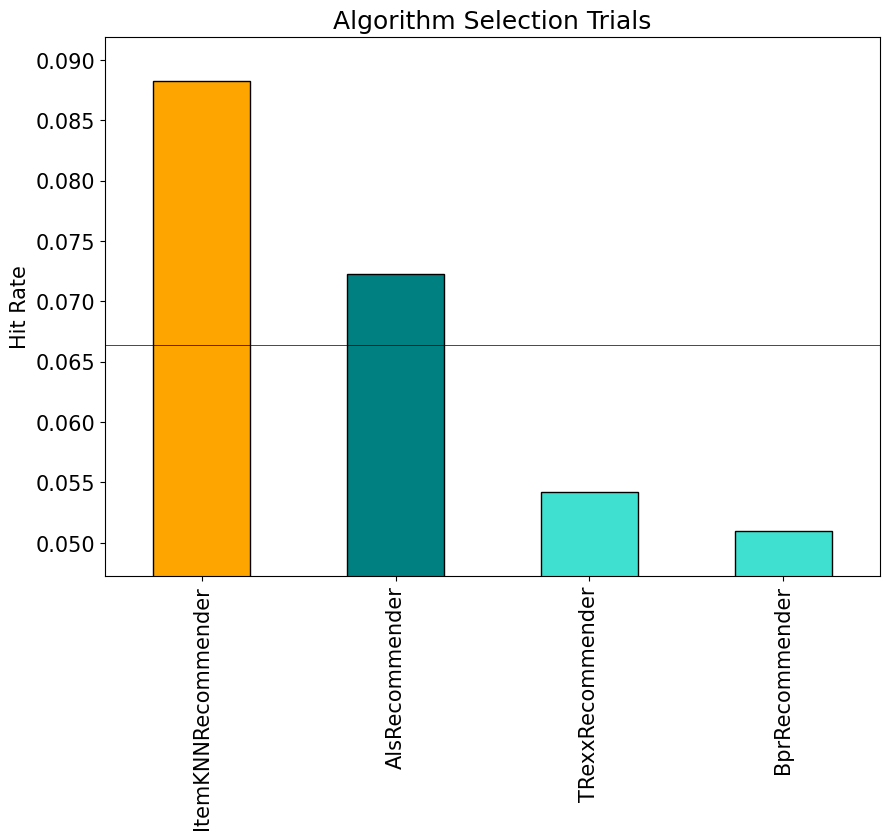

In [11]:


def plot_model_selection_scores(_pipeline):
    # Each trial is a row in a dataframe that contains
    # Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
    trials = _pipeline.completed_trials_summary_[
        _pipeline.completed_trials_summary_["Step"].str.contains("Model Selection")
    ]
    name_of_score_column = f"Score ({_pipeline._inferred_score_metric[0].name})"
    trials.replace([np.inf, -np.inf], np.nan, inplace=True)
    trials.dropna(subset=[name_of_score_column], inplace=True)
    scores = trials[name_of_score_column].tolist()
    models = trials["Algorithm"].tolist()
    
    y_margin = 0.10 * (max(scores) - min(scores))
    s = pd.Series(scores, index=models).sort_values(ascending=False)
    
    colors = []
    for f in s.keys():
        if f.strip() == _pipeline.selected_model_.strip():
            colors.append("orange")
        elif s[f] >= s.mean():
            colors.append("teal")
        else:
            colors.append("turquoise")
    
    fig, ax = plt.subplots(1)
    ax.set_title("Algorithm Selection Trials")
    ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
    ax.set_ylabel("Hit Rate")
    s.plot.bar(ax=ax, color=colors, edgecolor="black")
    ax.axhline(y=s.mean(), color="black", linewidth=0.5)
    plt.show()

plot_model_selection_scores(automl_pipeline)

<a id='hyperparameter-tuning'></a>
### Hyperparameter Tuning

Hyperparameter Tuning is the last stage of the AutoMLx pipeline, and focuses on improving the chosen algorithm's score on the dataset. We use a novel iterative algorithm to search across many hyperparameter dimensions, and converge automatically when optimal hyperparameters are identified. Each trial represents a particular hyperparameter configuration for the selected model.


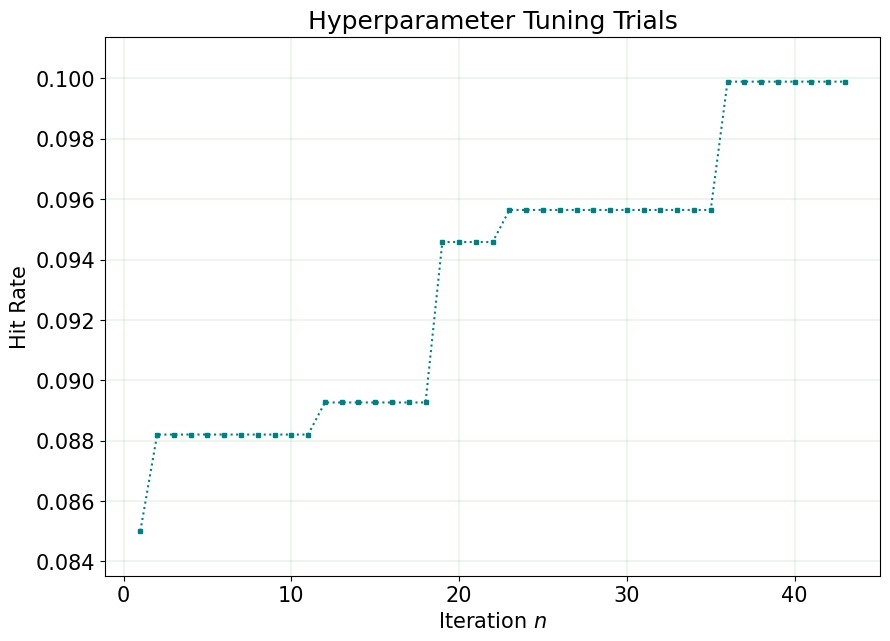

In [12]:


def plot_hp_tuning_scores(_pipeline):
    # Each trial is a row in a dataframe that contains
    # Algorithm, Number of Samples, Number of Features, Hyperparameters, Score, Runtime, Memory Usage, Step as features
    trials = _pipeline.completed_trials_summary_[
        _pipeline.completed_trials_summary_["Step"].str.contains("Model Tuning")
    ]
    name_of_score_column = f"Score ({_pipeline._inferred_score_metric[0].name})"
    trials.replace([np.inf, -np.inf], np.nan, inplace=True)
    trials.dropna(subset=[name_of_score_column], inplace=True)
    trials.drop(trials[trials["Finished"] == -1].index, inplace=True)
    trials["Finished"] = trials["Finished"].apply(
        lambda x: time.mktime(datetime.datetime.strptime(x, "%a %b %d %H:%M:%S %Y").timetuple())
    )
    trials.sort_values(by=["Finished"], ascending=True, inplace=True)
    scores = trials[name_of_score_column].tolist()
    score = []
    score.append(scores[0])
    for i in range(1, len(scores)):
        if scores[i] >= score[i - 1]:
            score.append(scores[i])
        else:
            score.append(score[i - 1])
    y_margin = 0.10 * (max(score) - min(score))
    fig, ax = plt.subplots(1)
    ax.set_title("Hyperparameter Tuning Trials")
    ax.set_xlabel("Iteration $n$")
    ax.set_ylabel("Hit Rate")
    ax.grid(color="g", linestyle="-", linewidth=0.1)
    ax.set_ylim(min(score) - y_margin, max(score) + y_margin)
    ax.plot(range(1, len(trials) + 1), score, "k:", marker="s", color="teal", markersize=3)
    plt.show()

plot_hp_tuning_scores(automl_pipeline)

<a id='modellist'></a>
## Advanced AutoMLx Configuration

You can also configure the AutoRecommender pipeline with suitable parameters according to your needs.

In [13]:


custom_pipeline = AutoRecommender().configure(
    model_list=[  # Specify the models you want the AutoMLx to consider
        "ItemKNNRecommender",
        "AlsRecommender",
        "BprRecommender",
    ],
    n_algos_tuned=2,  # Choose how many models to tune
    search_space={  # You can specify the hyperparameters and ranges we search for each model
        "ItemKNNRecommender": {"num_of_neighbors": {"range": [10, 30], "type": "continuous"}}
    },
    max_tuning_trials=20,  # The maximum number of tuning trials. Can be integer or Dict (max number for each model)
    score_metric="recall",  # Any of the metrics available, see the documentation for a list of supported values
)

<a id='custom-validation'></a>
## Use a custom validation set

You can specify a custom validation set that you want AutoMLx to use to evaluate the quality of models and configurations.

In [14]:


training_data, validation_data = AutoRecommender.train_test_split(data=training_data, col_types=col_types)


# We run again the AutoML pipeline with the custom training/validation split we just created, and some advanced settings that we can specify directly in the fit method.

In [15]:


custom_pipeline = custom_pipeline.fit(
    training_data,
    col_types,
    validation_data,
    time_budget=20,  # Specify time budget in seconds
)

[2024-09-11 08:31:42,012] [automlx.interface] Dataset shape: (49055,3)


[2024-09-11 08:31:42,080] [automlx.process] Running Model Generation


[2024-09-11 08:31:42,128] [automlx.process] Model Generation completed.


[2024-09-11 08:31:42,160] [automlx.model_selection] Running Model Selection


[2024-09-11 08:31:43,815] [automlx.model_selection] Model Selection completed - Took 1.654 sec - Selected models: [['ItemKNNRecommender', 'AlsRecommender']]


[2024-09-11 08:31:43,923] [automlx.trials] Running Model Tuning for ['ItemKNNRecommender']


[2024-09-11 08:31:47,504] [automlx.trials] Best parameters for ItemKNNRecommender: {'n_recommendations': 10, 'num_of_neighbors': 10, 'bias': 0.010099998000000002, 'hist_len': 10, 'reciprocal_ranking': False, 'normalize_scores': False, 'cache_users_states': True}


[2024-09-11 08:31:47,506] [automlx.trials] Model Tuning completed. Took: 3.583 secs


[2024-09-11 08:31:47,640] [automlx.trials] Running Model Tuning for ['AlsRecommender']


[2024-09-11 08:31:51,820] [automlx.trials] Best parameters for AlsRecommender: {'n_recommendations': 10, 'iterations': 10, 'factors': 16, 'regularization': 0.00044721247746457157, 'cache_users_states': True}


[2024-09-11 08:31:51,821] [automlx.trials] Model Tuning completed. Took: 4.181 secs


[2024-09-11 08:31:52,277] [automlx.interface] Re-fitting pipeline


[2024-09-11 08:31:52,287] [automlx.final_fit] Skipping updating parameter seed, already fixed by FinalFit_06ccaa75-4


[2024-09-11 08:31:53,683] [automlx.interface] AutoMLx completed.


Now that the custom AutoML pipeline is completed, we can generate recommendations.
Note that the pipeline's `recommend` method is equivalent to `predict`.

In [16]:


custom_pipeline.recommend(subjects=recommendation_subjects, n_recommendations=5)

,user_id,movie_id,score
0,834,7,27.642145
1,834,121,26.133169
2,834,50,25.412533
3,834,405,24.929107
4,834,181,24.016132


<a id='evaluation'></a>
## Final evaluation of the best model

Finally, we evaluate the best model found on the test data we have. If no metric is specified, the pipeline computes the score using the same metric used to run the Hyperparameter Tuning, which in this case is the Recall, as we defined at pipeline creation.

In this example, instead, we ask the pipeline to perform the evaluation using Normalized Discounted Cumulative Gain (NDCG), a common ranking metric. Our online documentation provides the list of the available metrics and how they are computed.

In [17]:


get_ipython().run_line_magic('precision', '4')
custom_pipeline.score(data=test_data, score_metric="ndcg")

  0%|          | 0/939 [00:00<?, ?it/s]

0.0300